# School objective functions

Max Kapur | [maxkapur.com](https://www.maxkapur.com/)

*N.B.* This is a working document, more of a set of personal notes than a finished product. Please see my other Github repositories or the paper included in this repo for somewhat more polished discussions of admissions markets.

------

Previous research has dodged the notion of school objective functions because it is hard to define a total ordering over the set of sets of students. However, it is worth considering what forms such objective functions could take, and attempting to inverse optimize for their parameters.

The possible "ingredients" of a school objective function are the cutoff $p$, the demand $D$, and the integral of scores over the set of admitted students $L$. $D$ and $L$ are functions of $p$. As argued in the paper, $L$ is shaped much like $D$, but lacks its desirable property of convexity, so I will disregard $L$ here. And $D$ is a function of $p$, so ultimately our school objectives $u_c$ will be too.

The objective function should be increasing in $p$ and $D$, and it would be nice to have a parameter $\sigma$ that expresses the school's preference for "selectivity" over "large class size."

It is apparent from the shape of the demand curve that a linear form such as $u_c= D_c + \sigma p_c$ is unsuitable. Then the optimum will *always* occur at $p=0$ or $p=1$ (or both, in an edge case). 

Instead, consider the *product* $D_c \cdot p_c^{\sigma}$, which can have its optimum anywhere on the open segment. Taking the log, it suffices to assume each school wants to maximize the following utility function:

$$u_c(p_c) = \log D_c + \sigma \log p_c$$

In this notebook, I show that this form of the utility function allows us to capture the heterogeneous behavior of schools in selecting their cutoffs. Although nonconcave, it is piecewise concave in a finite number of pieces, so finding the maximum is quite easy. It is also differentiable, so we can dream up a variety of iterative strategies. 

In [1]:
using OneTest

using Plots, Plots.PlotMeasures
using LinearAlgebra
using Statistics: cor, mean
using DataFrames, CSV
using Optim
using Random
# import DeferredAcceptance: deferredacceptance

┌ Info: Precompiling OneTest [1ef6a4a2-16d2-490f-ac5f-8848ea0bfd49]
└ @ Base loading.jl:1317


## Pallet Town

We will use the toy market of Pallet Town to check out the shape of some objective functions. 

In [2]:
ptown = Market(log.([1, 3, 2, 6]), [0.1, 0.2, 0.3, 0.2]) |> sort
p_star = equilibrium(ptown)

4-element Vector{Float64}:
 0.19999999999999996
 0.29999999999999993
 0.39999999999999997
 0.6

In [3]:
ptown.gamma

4-element Vector{Float64}:
 2.0
 1.0
 3.0000000000000004
 6.0

Since we are using the same kind of `Market` struct, it has a capacity built in. However, this isn't relevant to the notion of equilibrium considered here; instead we care about the taste parameters $\sigma$. Below, I have just picked some random numbers; in this case, the market-clearing equilibrium for school 2 *also* happens to optimize its utility function, but this doesn't hold for the other schools.

In [4]:
sigma = [0.9, 1.0, 3.0, 0.5]

4-element Vector{Float64}:
 0.9
 1.0
 3.0
 0.5

In [2]:
function plotdemandcurve(market::Market, c::Int; p_fix=nothing, st=0.005, sigma=1)
    if p_fix === nothing
        p_fix = equilibrium(market)
    end
    
    p_try = 0:st:1
    
    dem = zeros(length(p_try))
    app = zeros(length(p_try))

    for (i, pc) in enumerate(p_try)
        p_store = p_fix[c]
        p_fix[c] = pc
        dem[i] = demand(market, p_fix)[c]
        app[i] = appeal(market, p_fix)[c]
        p_fix[c] = p_store
    end
    
    function u(p)
        p_copy = copy(p_fix)
        p_copy[c] = p
        return utility(market, sigma, p_copy)[c]
    end
    
    util = [u(p) for p in p_try[2:end-1]]
    
    # Just some affine scaling to make plot legible
    util .-= minimum(util)
    util ./= maximum(util)
    util .*= maximum(dem)

    util = [0, util..., 0]
    

    pl = plot(xlim = (0, 1), xlabel="p",
              ylim=(0, 1.1*maximum(dem)),
              size=(700, 500), legend=:right)


    vline!([p_fix[c]], color=:black, ls=:dash, lw=.75, label="current cutoff")
    plot!(p_try, dem, color=:rebeccapurple, lw=1.5, label="demand")
    plot!(p_try, app, color=:olivedrab, lw=1.5, label="appeal")
    plot!(p_try, util, color=:gold, lw=1.5, label="utility")

    sigma = round(sigma, digits=3)
    annotate!([(0.9, 0.1, text("σ = $sigma", 9, :right))])
        
    return pl
end

ex_utility_function = plotdemandcurve(ptown, 2, sigma=1)

# savefig(ex_utility_function, "SchoolIncentives/plots/cloud-function-example.pdf")
# savefig(ex_utility_function, "SchoolIncentives/plots/cloud-function-example.png")

ex_utility_function

LoadError: UndefVarError: ptown not defined

┌ Info: Saved animation to 
│   fn = C:\Users\Max\OneTest\tmp.gif
└ @ Plots C:\Users\Max\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Max\\OneTest\\tmp.gif")
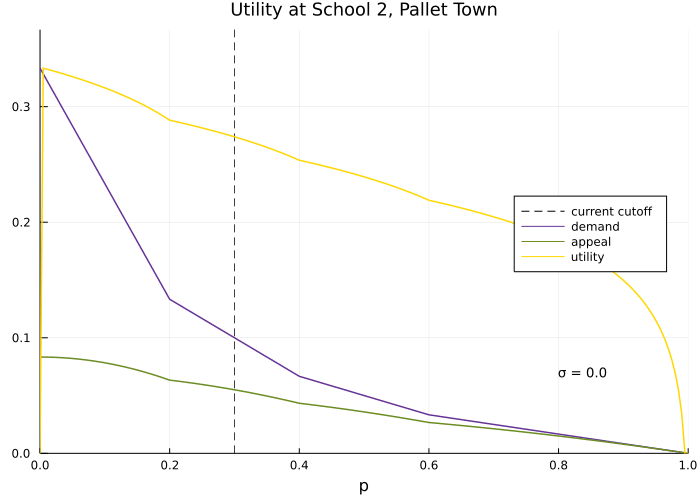

In [6]:
function plotdemandcurve_anim(market::Market, c::Int; p_fix=nothing, st=0.005, title="")
    if p_fix === nothing
        p_fix = equilibrium(market)
    end
    
    p_try = 0:st:1
    
    dem = zeros(length(p_try))
    app = zeros(length(p_try))
    
    for (i, pc) in enumerate(p_try)
        p_store = p_fix[c]
        p_fix[c] = pc
        dem[i] = demand(market, p_fix)[c]
        app[i] = appeal(market, p_fix)[c]
        p_fix[c] = p_store
    end
    
    ran = 2 .^(-5:0.2:7)
    pl = @animate for sigma in vcat(0, ran, reverse(ran)[2:end])

        utility = log.(dem[2:end-1]) + sigma * log.(p_try[2:end-1])

        # Just some affine scaling to make plot legible
        utility .-= minimum(utility)
        utility ./= maximum(utility)
        utility .*= maximum(dem)
        
        utility = [0, utility..., 0]

        plot(xlim = (0, 1), xlabel="p", ylim=(0, 1.1*maximum(dem)), size=(700, 500), legend=:right,
             title=title, titlefontsize=12)


        vline!([p_fix[c]], color=:black, ls=:dash, lw=.75, label="current cutoff")
        plot!(p_try, dem, color=:rebeccapurple, lw=1.5, label="demand")
        plot!(p_try, app, color=:olivedrab, lw=1.5, label="appeal")
        plot!(p_try, utility, color=:gold, lw=1.5, label="utility")
        
        sigma = round(sigma, digits=2)
        annotate!([(0.8, 0.07, text("σ = $sigma", 9, :left))])
    end

    return pl
end

gif(plotdemandcurve_anim(ptown, 2, title="Utility at School 2, Pallet Town"), fps=15)

## Incentive gradients and local equilibrium search

With $u_c(p_c) = \log D_c + \sigma \log p_c$, we have $$u'_c(p_c) = \frac{1}{D_c} D'_c + \frac{\sigma}{p_c} = \frac{1}{A_{c.} p + \frac{1}{\Gamma}\gamma_c} A_{cc} + \frac{\sigma}{p_c}$$

where $A$ is the demand matrix given in the paper, and $p$ is sorted.

In [7]:
incentivegradient(ptown, sigma, p_star)

4-element Vector{Float64}:
  1.1666666666666674
  8.881784197001252e-16
  5.000000000000001
 -1.666666666666666

If the market is well-behaved, we can find local equilibria by following the incentive gradient at each school. Because the objective functions are not convex, these will only be local. Also, the derivative is undefined when $p = 0$ or $p=1$, so it is useful to use clamping to avoid these extremes.

In [8]:
iterates = localequilibriumsearch(ptown, sigma; maxit=100, p0=fill(.5, length(ptown)))
@show iterates[end]

iterates[end] = [0.21597186819486297, 0.27386735447571464, 0.7479015589876018, 0.3417275221373379]


4-element Vector{Float64}:
 0.21597186819486297
 0.27386735447571464
 0.7479015589876018
 0.3417275221373379

┌ Info: Saved animation to 
│   fn = C:\Users\Max\OneTest\SchoolIncentives\plots\incentive-gradient-anim.gif
└ @ Plots C:\Users\Max\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Max\\OneTest\\SchoolIncentives\\plots\\incentive-gradient-anim.gif")
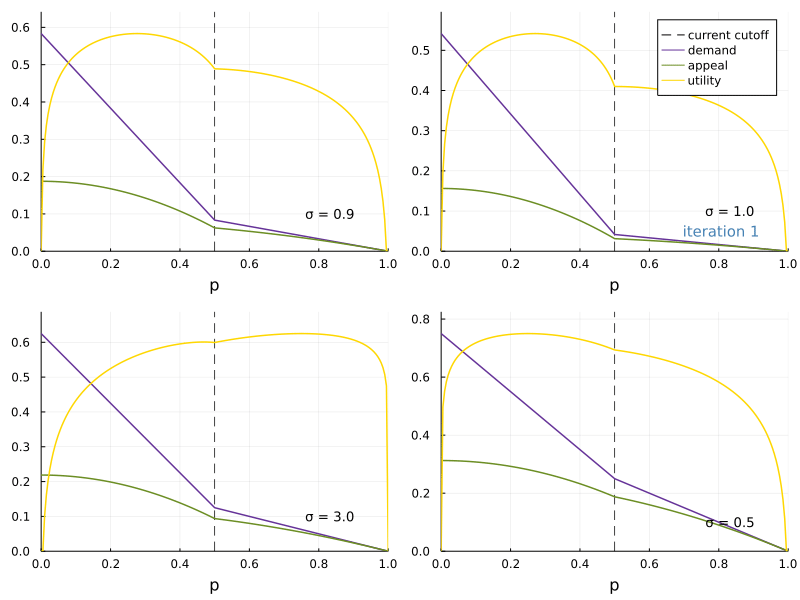

In [9]:
function plotiterates(market, sigma, iterates, st=0.005)
    p_try = 0:st:1
    
    res = @animate for (j, p_fix) in enumerate(iterates)
        pl = plot(layout=length(market), size=(800, 600))
        
        for c in 1:length(market) 

            dem = zeros(length(p_try))
            app = zeros(length(p_try))

            for (i, pc) in enumerate(p_try)
                p_store = p_fix[c]
                p_fix[c] = pc
                dem[i] = demand(market, p_fix)[c]
                app[i] = appeal(market, p_fix)[c]
                p_fix[c] = p_store
            end
            
            
            utility = log.(dem[2:end-1]) + sigma[c] * log.(p_try[2:end-1])

            # Just some affine scaling to make plot legible
            utility .-= minimum(utility)
            utility ./= maximum(utility)
            utility .*= maximum(dem)

            utility = [0, utility..., 0]

            plot!(pl, xlim = (0, 1), xlabel="p", ylim=(0, 1.1*maximum(dem)), legend=:none, subplot=c)

            vline!(pl, [p_fix[c]], color=:black, ls=:dash, lw=.75, label="current cutoff", subplot=c)
            plot!(pl, p_try, dem, color=:rebeccapurple, lw=1.5, label="demand", subplot=c)
            plot!(pl, p_try, app, color=:olivedrab, lw=1.5, label="appeal", subplot=c)
            plot!(pl, p_try, utility, color=:gold, lw=1.5, label="utility", subplot=c)

            s = round(sigma[c], digits=3)
            annotate!(pl, [(0.9, 0.1, text("σ = $s", 9, :right))], subplot=c)
            
        end
        
        plot!(pl, legend=:topright, subplots=2)
        annotate!(pl, [(0.7, 0.05, text("iteration $j", 10, :left, :steelblue))], subplots=2)
    end
    
    return res
end

anim = plotiterates(ptown, sigma, iterates)
# map(png, frame(anim))
gif(anim, "./SchoolIncentives/plots/incentive-gradient-anim.gif", fps=10)

Looking at school 3 (top right pane), we can see there is a globally better choice at $p \approx 0.17$, whereas this method has settled on a local maximum. 

## Best-response dynamics and global equilibrium search

Next, let's consider a best-response dynamics scheme where each school changes its cutoff to its global maximum on the assumption that other schools stay in the same place. 

Although the utility functions aren't concave, they are composed of concave segments, so it suffices to do maximize within each segment and report the overall best.

Helpfully, we also have gradient info, so we can analytically solve the equation $u_c'(p_c) = 0$ for $p_c$ on the segment. Then we compare the utility associated with the local maximizer on each segment to compute the overall best response. This is contained in the function `bestresponse_it()`, wrapped by `bestresponse()` which does multiple iterations. 

iterates[end] = [0.4440789473684211, 0.17739661654135336, 0.75, 0.2759502923976608]


┌ Info: Saved animation to 
│   fn = C:\Users\Max\OneTest\SchoolIncentives\plots\best-response-anim.gif
└ @ Plots C:\Users\Max\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Max\\OneTest\\SchoolIncentives\\plots\\best-response-anim.gif")
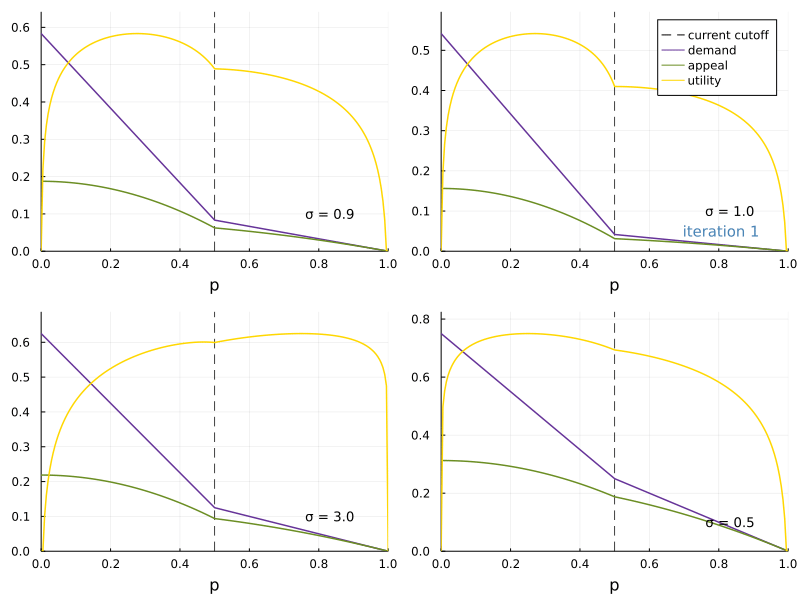

In [10]:
# Choose one of the following to see cycling

# a = [ 0.24, 0.94, 0.06, 0.82,]
# a = [0.426, 0.5, 0.638, 0.331]
a = fill(0.5, 4)

iterates = bestresponse(ptown, sigma, a)
@show iterates[end]
anim = plotiterates(ptown, sigma, iterates)

# write png frames to cwd
# map(png, frame(anim))

gif(anim, "./SchoolIncentives/plots/best-response-anim.gif", fps=3)

In [11]:
function plotiterates_parallel(sort_order, iterates...)
    
    ub = maximum(maximum(maximum(cuts) for cuts in its) for its in iterates)
    
    C = length(iterates[begin][begin])
    T = length(iterates[begin])
    
    pl = plot(layout=(length(iterates), 1), size = (800, 220*length(iterates)),
              legend=false, ylabel="cutoff (p)", ylim=(-0.025, ub+0.025), xlim=(0, T-1),
              leftmargin=20px, bottommargin=20px)
    
    lses = [:solid, :dash, :dashdot, :dot]
    
    for (p, its) in enumerate(iterates)
        
        for g in 1:C
            c = sort_order[g]
            plot!(pl[p], 0:T-1, [its[t][c] for t in 1:T],
                  ls = lses[g%4 + 1], lw=1.5)
        end
        
        if p == length(iterates)
            plot!(pl[p], xlabel="best response iteration")
        end
    end
            
    
    return pl
end

plotiterates_parallel (generic function with 1 method)

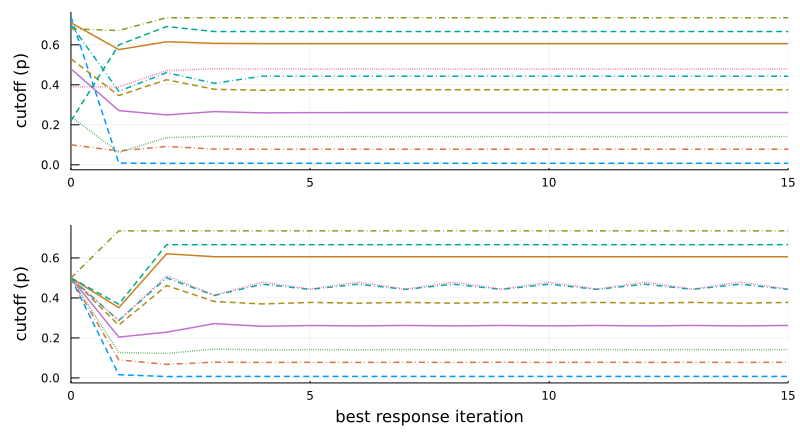

In [12]:
viridian = Market([0.43, 0.43, 0.5, 0.23, 0.69, 0.01, 0.47, 0.32, 0.13, 0.73], fill(Inf, 10))
viridian_σ = [0.59, 0.92, 0.03, 1.13, 0.19, 2.24, 1.08, 1.81, 0.31, 2.78]
viridian_p = [0.48, 0.53, 0.74, 0.39, 0.1, 0.22, 0.7, 0.71, 0.24, 0.68]

nit = 15
iterates1 = bestresponse(viridian, viridian_σ, viridian_p, nit=nit)
iterates2 = bestresponse(viridian, viridian_σ, fill(0.5, length(viridian)), nit=nit)
iterates3 = bestresponse(viridian, viridian_σ, fill(0., length(viridian)), nit=nit)

so = sortperm(iterates1[end])
   
pl = plotiterates_parallel(so, iterates1, iterates2)

# savefig(pl, "SchoolIncentives/plots/br-cycles.pdf")
# savefig(pl, "SchoolIncentives/plots/br-cycles.png")

pl

## Inverse optimization of school objective functions

The animations above suggests that as expected, the location of the optimum cutoff for each school increases from just above zero to just below one as $\sigma$ varies from just above zero to nearly infinity. 

This means that given the equilibrium cutoff of a given school and the demand function, we can use a secant method to find the value of $\sigma$ for which the school's chosen cutoff is optimal. This will be different than the values of $\sigma$ given above, although we can see from the graph that $\sigma_2 = 1$. 

This will not work in every situation. It is clear from the graph above that there is no value of $\sigma$ for which $p= 0.4$ is the maximizer. As $\sigma$ passes from $1$ to $2$, there is a discontinuity where the location of the optimum jumps from around $0.37$ to $0.43$. 

On the other hand, this becomes less of an issue in a market with many schools, as can be seen in the following graph.

┌ Info: Saved animation to 
│   fn = /Users/maxkapur/OneDrive/2021/OneTest/SchoolIncentives/plots/cloud-function-sigma.gif
└ @ Plots /Users/maxkapur/.julia/packages/Plots/ldLtW/src/animation.jl:104


Plots.AnimatedGif("/Users/maxkapur/OneDrive/2021/OneTest/SchoolIncentives/plots/cloud-function-sigma.gif")
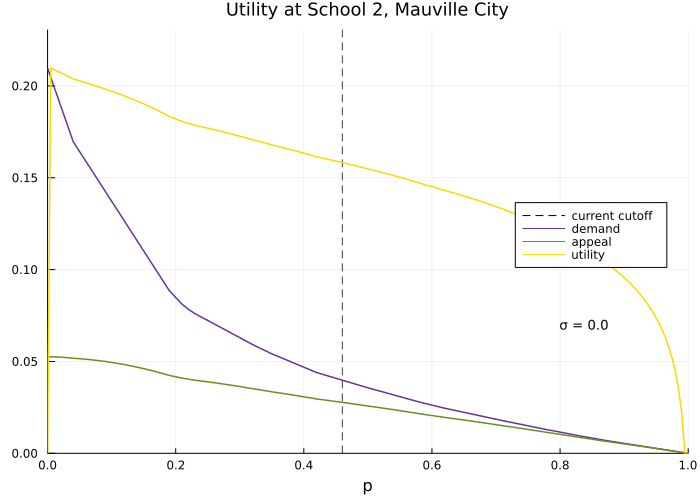

In [15]:
mauville = Market([0.266, 0.552, 0.541, 0.389, 0.645, 0.393, 0.374, 0.189, 0.479, 0.809, 0.9, 0.492, 0.565, 0.493, 0.021, 0.415, 0.946, 0.216, 0.888, 0.283],
                   fill(Inf, 20))#,[0.088, 0.085, 0.1, 0.083, 0.095, 0.071, 0.031, 0.091, 0.072, 0.036, 0.005, 0.01, 0.046, 0.045, 0.048, 0.002, 0.003, 0.076, 0.05, 0.098])
cuts = [0.59, 0.46, 0.88, 0.04, 0.99, 0.78, 0.19, 0.5, 0.21, 0.42, 0.83, 0.87, 0.23, 0.35, 0.32, 0.58, 0.42, 0.22, 0.62, 0.71]

# write png frames to cwd
# map(png, frame(anim))

anim = plotdemandcurve_anim(mauville, 2, title="Utility at School 2, Mauville City", p_fix=cuts)
gif(anim, "./SchoolIncentives/plots/cloud-function-sigma.gif", fps=15)

If this is the equilibrium, then looks like school 2 has $\sigma = 1.2$. We can verify this graphically, or numerically, by noting that the "best response" at the current cutoffs *is* the current cutoff for school 2, $p=0.46$. 

In [7]:
plotdemandcurve(mauville, 2, p_fix=cuts, sigma=1.2)

LoadError: UndefVarError: cuts not defined

In [13]:
bestresponse_it(mauville, fill(1.2, 20), cuts)[2] # = p

0.460554178742218

This suggests that the reverse optimization problem is to find the root of the following function, which we can do using the secant method

In [14]:
function g(s)
    return [cuts[2] - bestresponse_it(mauville, fill(s, 20), cuts)[2]]
end

# s-value found using secantroot(), not exported
g(1.1943889340897476) # ≈ 0

1-element Vector{Float64}:
 0.0004271877983024752

In [3]:
sigma_star, err = sigmainvopt(ptown, p_star, verbose=true)
println(err) # Should be zero

LoadError: UndefVarError: ptown not defined

In [16]:
sigma_star, err = sigmainvopt(mauville, cuts)
println(err) # Should be zero

[-3.9498804614845895e-6, -2.893957936067615e-6, -1.0205710596622453e-6, -9.761574099965975e-6, -7.539133261014186e-7, -1.3305333479429748e-7, -0.01643050522748951, -1.1067303656853156e-7, -0.0666638868119433, -0.022268090375612115, -3.181719231748481e-6, -6.87915091668323e-7, -0.08965149056634689, -5.2581058840317496e-8, -1.9517634231025482e-7, -1.852051330741844e-6, -0.018739289302313, 0.05848003608762123, -7.1231183246256435e-6, 7.244930017025197e-6]


In [17]:
sigmainvopt(ptown, [0.4, 0.5, 0., 0.3])

([0.7164184622289997, 1.0000026562449817, 0.0, 0.5387570574871838], [1.7948878139328883e-7, 6.640603634755493e-7, 0.0, -6.677342744010328e-6])

For a big market, it is helpful to use a `Float16` instead. 

In [8]:
U = Float32
okc = Market(50)
okc = Market((convert(Vector{U}, i) for i in (okc.qualities, okc.capacities, okc.gamma))...)
cut = rand(U, length(okc))
@time res, errvec = sigmainvopt(okc, cut, maxit=50, verbose=true)
println(errvec) # Should be zero

c = 1
  Iterations in bisection: 25
c = 2
  Iterations in bisection: 36
c = 3
  Iterations in bisection: 25
c = 4
  Iterations in bisection: 34
c = 5
  Iterations in bisection: 25
c = 6
  Iterations in bisection: 25
c = 7
  Iterations in bisection: 25
c = 8
  Iterations in bisection: 26
c = 9
  Iterations in bisection: 25
c = 10
  Iterations in bisection: 25
c = 11
  Iterations in bisection: 25
c = 12
  Iterations in bisection: 28
c = 13
  Iterations in bisection: 24
c = 14
  Iterations in bisection: 25
c = 15
  Iterations in bisection: 33
c = 16
  Iterations in bisection: 27
c = 17
  Iterations in bisection: 26
c = 18
  Iterations in bisection: 28
c = 19
  Iterations in bisection: 25
c = 20
  Iterations in bisection: 26
c = 21
  Iterations in bisection: 27
c = 22
  Iterations in bisection: 25
c = 23
  Iterations in bisection: 28
c = 24
  Iterations in bisection: 25
c = 25
  Iterations in bisection: 30
c = 26
  Iterations in bisection: 25
c = 27
  Iterations in bisection: 24
c = 28
  I

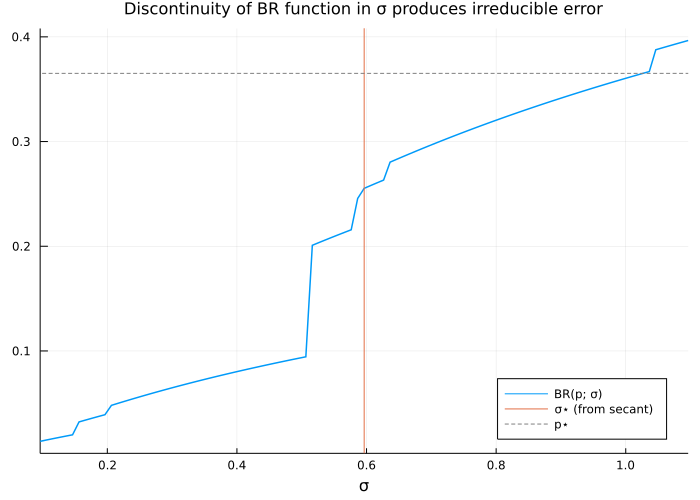

c = 26


In [9]:
# Orange line should indicate the zero.
# Let's plot the one with the highest error to see what went wrong.
let c = argmax(errvec)
    @show c
    function f(x)
        y = zeros(U, length(okc))
        y[c] = x
        return bestresponse_it(okc, y, cut)[c]
    end
    
    z = res[c]-0.5:0.01:res[c]+0.5
    pl = plot(z, f.(z), xlim=(z[1], z[end]), size=(700, 500),
              xlabel="σ", label="BR(p; σ)", lw=1.5,
              title="Discontinuity of BR function in σ produces irreducible error",
              titlefontsize=11, legend=:bottomright)
    vline!(pl, [res[c]], label="σ⋆ (from secant)")
    hline!(pl, [cut[c]], ls=:dash, c=:gray50, label="p⋆")
    
    savefig(pl, "SchoolIncentives/plots/best-response-discontinuity.pdf")
    savefig(pl, "SchoolIncentives/plots/best-response-discontinuity.png")
    
    display(pl)
end

# Edge case. Discontinuity straddles the zero of BR(p) - p. 

In [52]:
function timer(n_markets)
    U = Float16
    N = rand(2:98, n_markets)
    T = zeros(Float64, n_markets)
    
    for i in 1:n_markets
        i % 20 == 1 && @show i
        okc = Market(N[i])
        okc = Market((convert(Vector{U}, i) for i in (okc.qualities, okc.capacities, okc.gamma))...)
        cut = rand(U, length(okc))
        # Take better of two runs
        T[i] = min(@elapsed sigmainvopt(okc, cut, verbose=false),
                   @elapsed sigmainvopt(okc, cut, verbose=false))
    end
    
    return N, T
end

@time N, T = timer(150)

i = 1
i = 21
i = 41
i = 61
i = 81
i = 101
i = 121
i = 141
 15.253388 seconds (47.62 M allocations: 14.478 GiB, 14.47% gc time)

([88, 34, 84, 2, 56, 85, 89, 70, 8, 63  …  11, 84, 8, 42, 14, 56, 49, 7, 7, 81], [0.3383037, 0.0121469, 0.2372776, 6.14e-5, 0.0833522, 0.2469018, 0.2747266, 0.1277086, 0.0007282, 0.1197182  …  0.0013078, 0.2827704, 0.0013559, 0.0387099, 0.0041672, 0.0716996, 0.0616073, 0.0003689, 0.0004014, 0.1694117])

In [84]:
# CSV.write("SchoolIncentives/InvOptTimes.csv", DataFrame(Pair(:nschools, N), Pair(:time, T)))
N, T = CSV.File("SchoolIncentives/InvOptTimes.csv") |> DataFrame |> eachcol

1500×2 DataFrameColumns
  Row │ nschools  time        
      │ Int64     Float64     
──────┼───────────────────────
    1 │       13   0.118662
    2 │       52   1.52145
    3 │       66   3.09644
    4 │       42   0.591426
    5 │       71   3.53511
    6 │       51   1.03801
    7 │       95  11.6739
    8 │       89   8.24427
    9 │       63   2.166
   10 │       72   4.07846
   11 │       38   0.49297
  ⋮   │    ⋮           ⋮
 1491 │       55   1.61722
 1492 │       86   6.25068
 1493 │       58   1.84249
 1494 │       96   9.91471
 1495 │       15   0.00772947
 1496 │       68   3.81527
 1497 │       46   0.96344
 1498 │       32   0.225969
 1499 │       76   4.14049
 1500 │       75   3.51821
             1479 rows omitted

In [53]:
function fit_powerlaw_logspace(x, y)
    n = length(x)
    logx = log.(x)
    logy = log.(y)
    
    a, b = [ones(n) logx]\logy
    a = exp(a)
    
    r2 = cor(x, a * x .^ b)^2
    
    return a, b, r2
end

function fit_powerlaw_xyspace(x, y; b0=4)
    n = length(x)
    
    # z = [a, b]
    f(z) = sum( (z[1] * x[i] ^ z[2] - y[i])^2 for i in 1:n)
    
    a, b = optimize(f, [1e-5, b0]) |> Optim.minimizer
    
    r2 = cor(a * x .^ b, y)^2
    return a, b, r2
end

a, b, r2_1 = fit_powerlaw_logspace(N, T)
c, d, r2_2 = fit_powerlaw_xyspace(N, T)

(1.7147980555786856e-6, 2.6647467638896014, 0.9692323088192456)

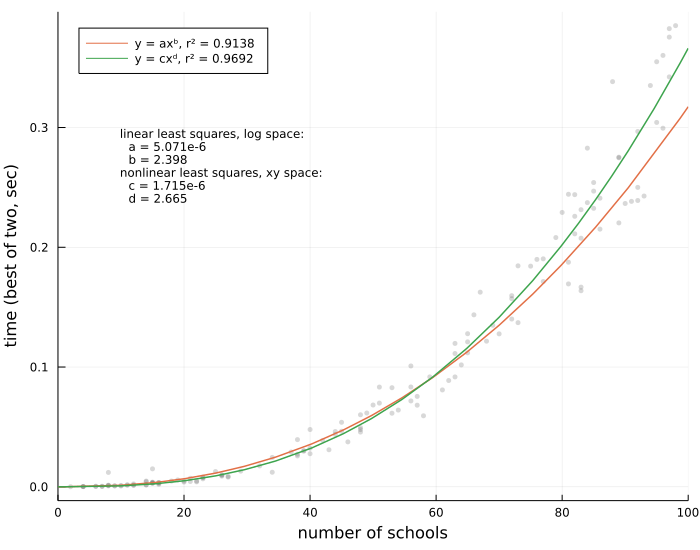

In [55]:
pl = scatter(N, T, label="", legend=:topleft,
             titlefontsize=11, size = (700, 550),
             xlabel ="number of schools", ylabel="time (best of two, sec)",
             ms=3, mc=:gray25, ma=0.2, msw=0,
             xlim=(0, 100))

plot!(pl, x-> a * x ^ b, lw=1.5, label="y = axᵇ, r² = $(round(r2_1, sigdigits=4))")
plot!(pl, x-> c * x ^ d, lw=1.5, label="y = cxᵈ, r² = $(round(r2_2, sigdigits=4))")

annotate!(pl, [(10, 0.3,
                text("linear least squares, log space:\n"*
                "  a = $(round(a, sigdigits=4))\n"*
                "  b = $(round(b, sigdigits=4))\n"*
                "nonlinear least squares, xy space:\n"*
                "  c = $(round(c, sigdigits=4))\n"*
                "  d = $(round(d, sigdigits=4))\n",
                8, :left, :top))])

# savefig(pl, "SchoolIncentives/plots/complexity-time.pdf")
# savefig(pl, "SchoolIncentives/plots/complexity-time.png")

pl

## Cloud hopping heuristic

The local optima of the utility function tend to form a quasiconcave shape. If this is true, then it isn't necessary to check every index $h$. Instead, just use binary search to find a low-high-low pattern.

Quasiconcavity almost always holds, especially in large markets. But here is an example where it fails. For this reason the default setting is not to use the heuristic. 

pewter_p[y] = 0.41


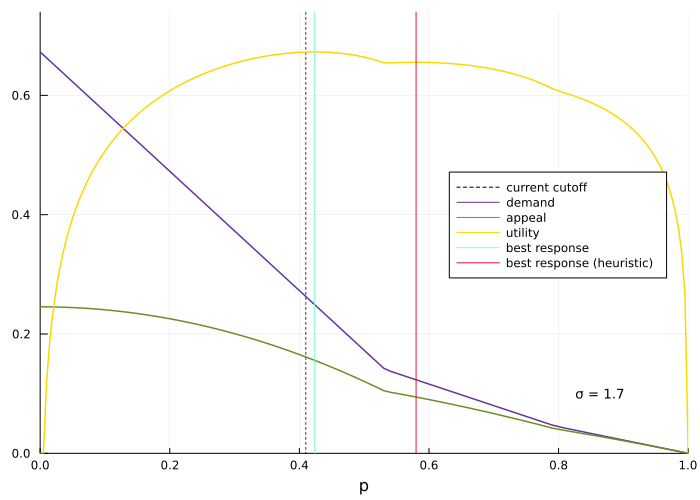

In [22]:
pewter = Market(log.([1.34, 2.24, 2.07, 2.07, 1.59]), rand(5))
pewter_σ = [1.69, 1.52, 1.7, 2.38, 14.06]
pewter_p = [0.81, 0.79, 0.41, 0.53, 0.54]
so = sortperm(pewter_p);

let y = 3
    @show pewter_p[y]
    br_accu = brforc(y, so, pewter, pewter_σ[y], pewter_p)
    br_heur = brforc(y, so, pewter, pewter_σ[y], pewter_p, heuristic=true)
    plotdemandcurve(pewter, y, p_fix = pewter_p, sigma=pewter_σ[y])
    vline!([br_accu], c=:aquamarine, label="best response")
    vline!([br_heur], c=:crimson, label="best response (heuristic)")
end

In [139]:
function heur_timer(n_markets)
    U = Float16
    N = rand(2:248, n_markets)
    T_accu = zeros(Float64, n_markets)
    T_heur = zeros(Float64, n_markets)
    agreed = zeros(Bool, n_markets)
    
    for i in 1:n_markets
        i % 50 == 1 && @show i
        okc = Market(N[i])
        okc = Market((convert(Vector{U}, i) for i in (okc.qualities, okc.capacities, okc.gamma))...)
        cut = rand(U, length(okc))
        y = rand(1:N[i])
        so = sortperm(cut)
        sigma = U(randexp())
        agreed[i] = isapprox(brforc(y, so, okc, sigma, cut), brforc(y, so, okc, sigma, cut, heuristic=true), atol=1e-2)
        T_accu[i] = minimum(@elapsed brforc(y, so, okc, sigma, cut) for _ in 1:3)
        T_heur[i] = minimum(@elapsed brforc(y, so, okc, sigma, cut, heuristic=true) for _ in 1:3)
    end
    
    return N, T_accu, T_heur, agreed
end

@time Nh, T_accu, T_heur, agreed = heur_timer(500)

i = 1
i = 51
i = 101
i = 151
i = 201
i = 251
i = 301
i = 351
i = 401
i = 451
 34.331731 seconds (47.44 M allocations: 31.645 GiB, 13.95% gc time, 0.80% compilation time)


([60, 176, 119, 233, 49, 147, 239, 4, 141, 132  …  61, 144, 167, 67, 6, 182, 2, 94, 238, 6], [0.0007991, 0.0183789, 0.005512, 0.044157, 0.0005594, 0.0137771, 0.0473753, 4.4e-6, 0.0101089, 0.0071808  …  0.0008827, 0.0093132, 0.0138181, 0.0008297, 6.7e-6, 0.0181647, 1.2e-6, 0.0026499, 0.0489917, 6.7e-6], [0.0002081, 0.0022239, 0.0010173, 0.002953, 0.0001409, 0.002428, 0.0034667, 8.8e-6, 0.0005286, 0.0012134  …  0.0003011, 0.0008909, 0.0015379, 0.000173, 4.3e-6, 0.002737, 4.0e-6, 0.0007597, 0.0028668, 5.0e-6], Bool[1, 1, 0, 0, 1, 1, 0, 0, 1, 1  …  1, 1, 1, 1, 1, 0, 0, 1, 0, 1])

In [153]:
a, b, r2_1 = fit_powerlaw_xyspace(Nh, T_accu, b0=2)
c, d, r2_2 = fit_powerlaw_xyspace(Nh, T_heur, b0=2)

(1.0026302565950647e-7, 1.9206784759100382, 0.7782403748790535)

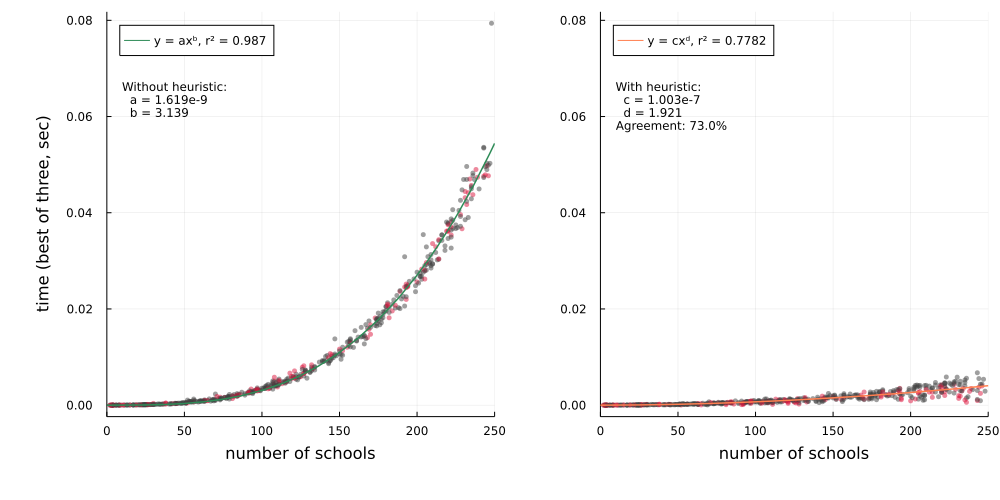

In [167]:
pl = plot(layout=2, legend=:topleft,
             titlefontsize=11, size = (1000, 500),
             xlabel ="number of schools", ylabel="time (best of three, sec)",
             xlim=(0, 250), link=:y, leftmargin=12mm, bottommargin=12mm)#, ylim=(0, 0.015))

color_idx = [i ? :gray25 : :crimson for i in agreed]
agreedpc = sum(agreed)/length(agreed)

scatter!(pl[1], Nh, T_accu, label="", ms=3, mc=color_idx, ma=0.5, msw=0,)
plot!(pl[1], x-> a * x ^ b, lw=1.5, label="y = axᵇ, r² = $(round(r2_1, sigdigits=4))", c=:seagreen)

annotate!(pl[1], [(10, maximum(T_accu)*.85,
                text("Without heuristic:\n"*
                "  a = $(round(a, sigdigits=4))\n"*
                "  b = $(round(b, sigdigits=4))\n",
                8, :left, :top))])

scatter!(pl[2], Nh, T_heur, label="", ms=3, mc=color_idx, ma=0.5, msw=0, ylabel="")
plot!(pl[2], x-> c * x ^ d, lw=1.5, label="y = cxᵈ, r² = $(round(r2_2, sigdigits=4))", c=:coral)

annotate!(pl[2], [(10, maximum(T_accu)*.85,
                text("With heuristic:\n"*
                "  c = $(round(c, sigdigits=4))\n"*
                "  d = $(round(d, sigdigits=4))\n"*
                "Agreement: $(round(100*agreedpc, sigdigits=4))%",
                8, :left, :top))])

savefig(pl, "SchoolIncentives/plots/heuristic-eval.pdf")
savefig(pl, "SchoolIncentives/plots/heuristic-eval.png")

pl

## Why I discarded the valuation function approach

Suppose each school has a valuation $v_c(x)$ of the interval from $[0,1]$, and that $v_c(x)$ is linear. Wlog, $v_c(x) = 1+ \sigma x$ where $\sigma$  is a parameter. The school's value is the integral of its valuation function over the set of admitted students:

$$\begin{align}V_c(p) &= \int_{\mu(p)} v_c(x)\,d\eta \\
&= \sum_{d=c}^{|C|} 
\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}}
\int_{p_d}^{p_d+1} v_c(x)\,dx \\
&= \sum_{d=c}^{|C|} 
\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}}
\left[\left(p_{d+1} - p_d\right) + \frac{\sigma}{2}\left(p_{d+1}^2 - p_d ^2\right)\right] \\
&= D_c(p) + \sigma L_c(p)
\end{align}
$$

We know from the results of the paper that both $D_c$ and $L_c$ are maximized by $p = 0$. Hence, this approach is not helpful. Moreover, it is not hard to see that the same outcome results from picking a valuation function of the form $v_c(x) = 1 + x^\sigma$, in which case (for reference)

$$\begin{align}V_c(p) &= \int_{\mu(p)} v_c(x)\,d\eta \\
&= \sum_{d=c}^{|C|} 
\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}}
\left[\left(p_{d+1} - p_d\right) + \frac{1}{\sigma+1}\left(p_{d+1}^{\sigma+1} - p_d ^{\sigma+1}\right)\right] \\
&= D_c(p) + L_c(p; \sigma)
\end{align}
$$

where $L_c(p; \sigma)$ is a generalization of the appeal function.
